In [8]:
import os
import warnings
import logging
import sys
import yaml
import subprocess
from pathlib import Path
from IPython.display import Image, display

# 1. Suppress TensorFlow C++ logs 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# 2. Suppress Python Warnings
warnings.filterwarnings("ignore")

# 3. Suppress internal Abseil/TensorFlow Python logging
logging.getLogger("absl").setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Safe import of TensorFlow (must be after env vars)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Set PYTHONPATH to project root so we can import 'src'
project_root = os.getcwd()
os.environ["PYTHONPATH"] = project_root
print(f"PYTHONPATH set to: {project_root}")

PYTHONPATH set to: /home/janek/Projekty/Sentiment


In [2]:
config_path = "configs/default.yaml"

with open(config_path) as f:
    base_cfg = yaml.safe_load(f)

print(f"Keys: {base_cfg}")

Keys: {'data': {'train_size': 0.5, 'test_size': 0.3, 'min_term_freq': 10, 'max_df_ratio': 0.4}, 'cascade': {'specialist_weight': 0.7}, 'bert': {'sentence_model': 'all-MiniLM-L6-v2', 'basic': {'model_name': 'distilbert-base-uncased-finetuned-sst-2-english', 'epochs': 3, 'batch_size': 16, 'max_len': 256, 'learning_rate': '2e-5', 'patience': 2}, 'specialist': {'epochs': 3, 'batch_size': 8, 'learning_rate': '1e-5', 'num_layers_to_freeze': 4, 'patience': 8}}, 'grid_search': {'models': ['linear_svm', 'logreg'], 'ngram_range': [[1, 1], [1, 2], [1, 3]], 'n_concepts': [0, 1000, 5000, 7000], 'z_threshold': [0, 1.0, 1.96, 2.576], 'sentiment_weight': [0.0, 30.0], 'C': [1.0]}}


In [3]:
print("--- Data Preprocessing ---")
subprocess.run(["python", "-m", "src.utils.loader", "--config", config_path], check=True)

--- Data Preprocessing ---


I0000 00:00:1771353848.202998    9019 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading IMDb reviews...
Found 418 duplicates.
Cleaning 49582 reviews...


100%|██████████| 49582/49582 [00:09<00:00, 5325.69it/s] 


Loaded dataset with 24791 train, 17353 val and 7438 test samples.
Loading done. JSON files saved to /home/janek/Projekty/Sentiment/data/IMDb
Preprocessing done. Parquet files saved to /home/janek/Projekty/Sentiment/data/preprocessed


CompletedProcess(args=['python', '-m', 'src.utils.loader', '--config', 'configs/default.yaml'], returncode=0)

In [5]:
# 2. Build Feature Factory
!python -m scripts.build_features --config configs/default.yaml

2026-02-18 13:56:28.937016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
--- PHASE 1: Building Base Vocabulary & Embeddings ---
Base Setup:   0%|                                         | 0/3 [00:00<?, ?it/s]Vocab missing for 1_1. Building from train split...
Cache missing for train split. Building matrix...
Cache missing for val split. Building matrix...
Base Setup:  33%|███████████                      | 1/3 [00:18<00:36, 18.18s/it]Vocab missing for 1_2. Building from train split...
Cache missing for train split. Building matrix

In [9]:
import pickle
from src.utils.paths import DATA_DIR

def inspect_stop_words(ngram_key="1_3", display_limit=100):
    """Loads and prints stop words, then safely drops them from memory."""
    vocab_path = DATA_DIR / "vocab" / f"vocab_{ngram_key}.pkl"
    
    if not vocab_path.exists():
        print(f"Vocab file not found at {vocab_path}. Run feature building first.")
        return
        
    with open(vocab_path, "rb") as f:
        vocab_data = pickle.load(f)
        
    stop_units = vocab_data.get("stop_units", [])
    
    print(f"Total dynamically generated stop units: {len(stop_units)}")
    print("-" * 50)
    print(stop_units[:display_limit])

# Run it
inspect_stop_words()

Total dynamically generated stop units: 51
--------------------------------------------------
['of the', 'as', ', but', 'in the', 'i', 'at', ')', 'for', 'the', 'from', 'so', 'in', '.', '. i', 'with', 'of', 'be', 'by', 'all', 'is', 'to', 'one', 'a', 'that', 'you', 'who', ', and', 'film', '"', 'are', '-', 's', 'he', "'", 'was', 'movie', 'on', 'out', 'an', 'have', 'but', '. the', "' s", '(', 'this', 'not', ',', 'like', 'it is', 'it', 'and']



--- Visualizing Unigrams (Baseline) ---
--- Visualizing: Concepts=0, Weight=0.0 ---
Saved importance plot to /home/janek/Projekty/Sentiment/results/figures/vocabulary/ngram_1_1_k0_w0_importance.png


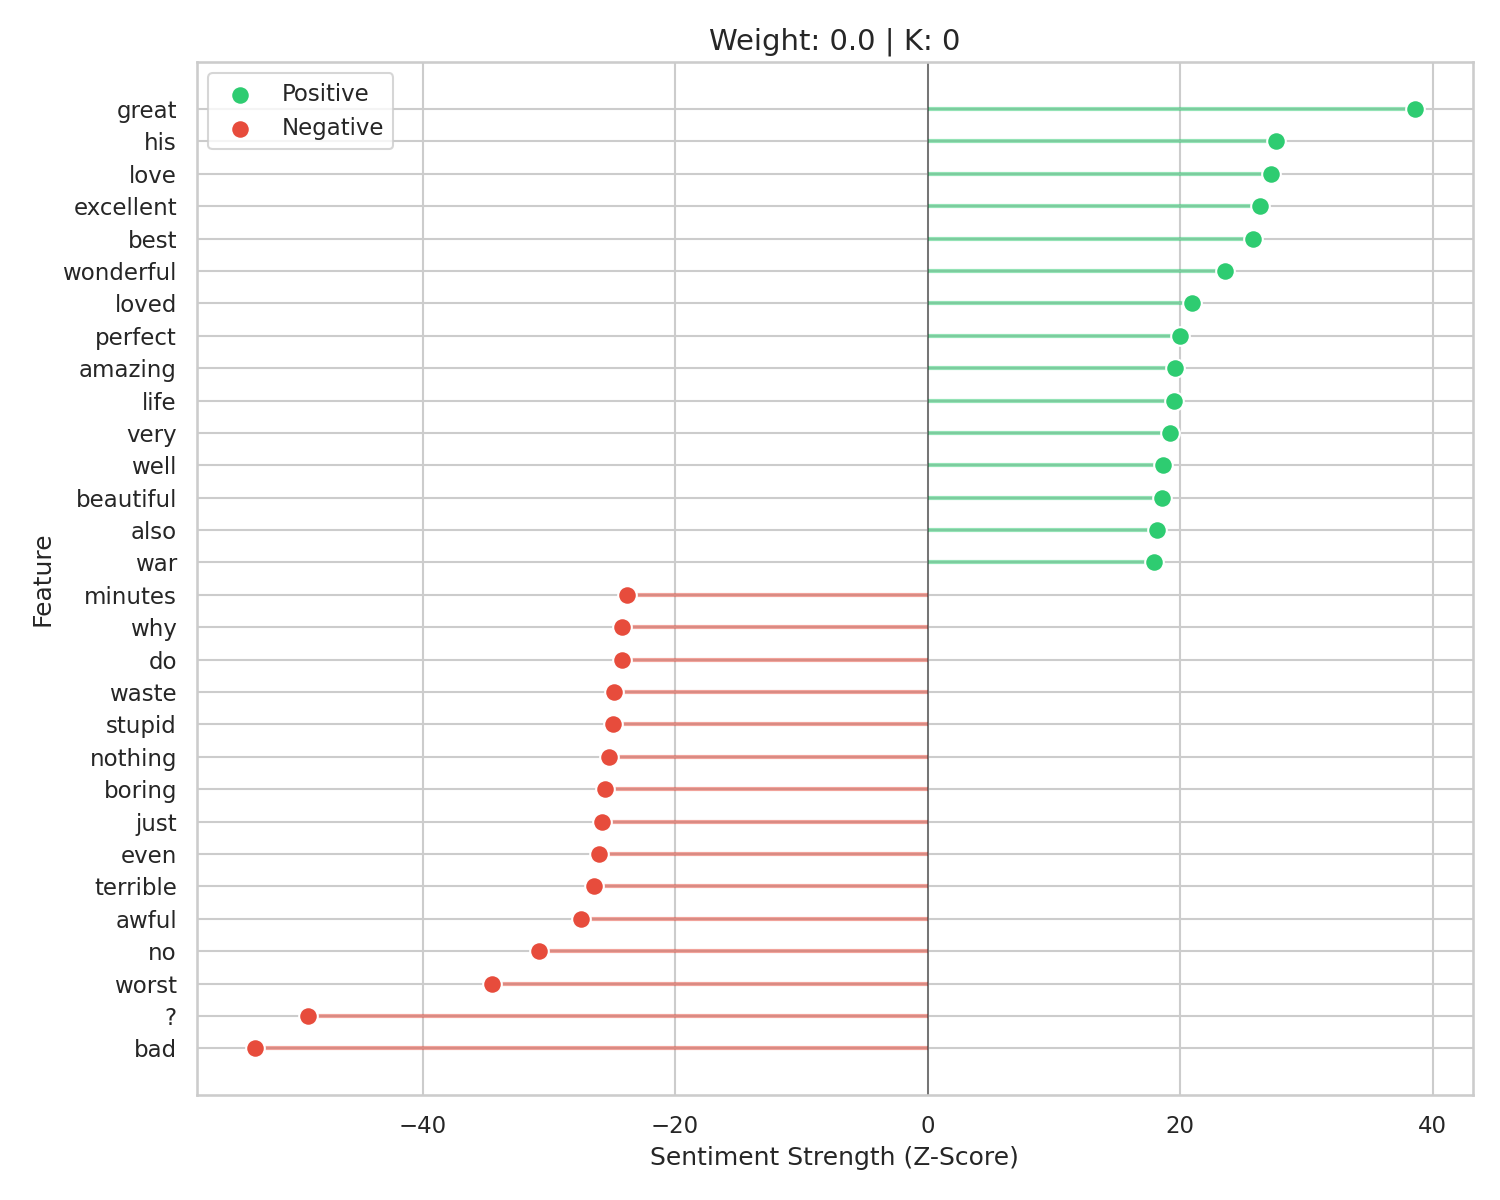

--- Visualizing: Concepts=0, Weight=0.0 ---
Saved importance plot to /home/janek/Projekty/Sentiment/results/figures/vocabulary/ngram_1_3_k0_w0_importance.png


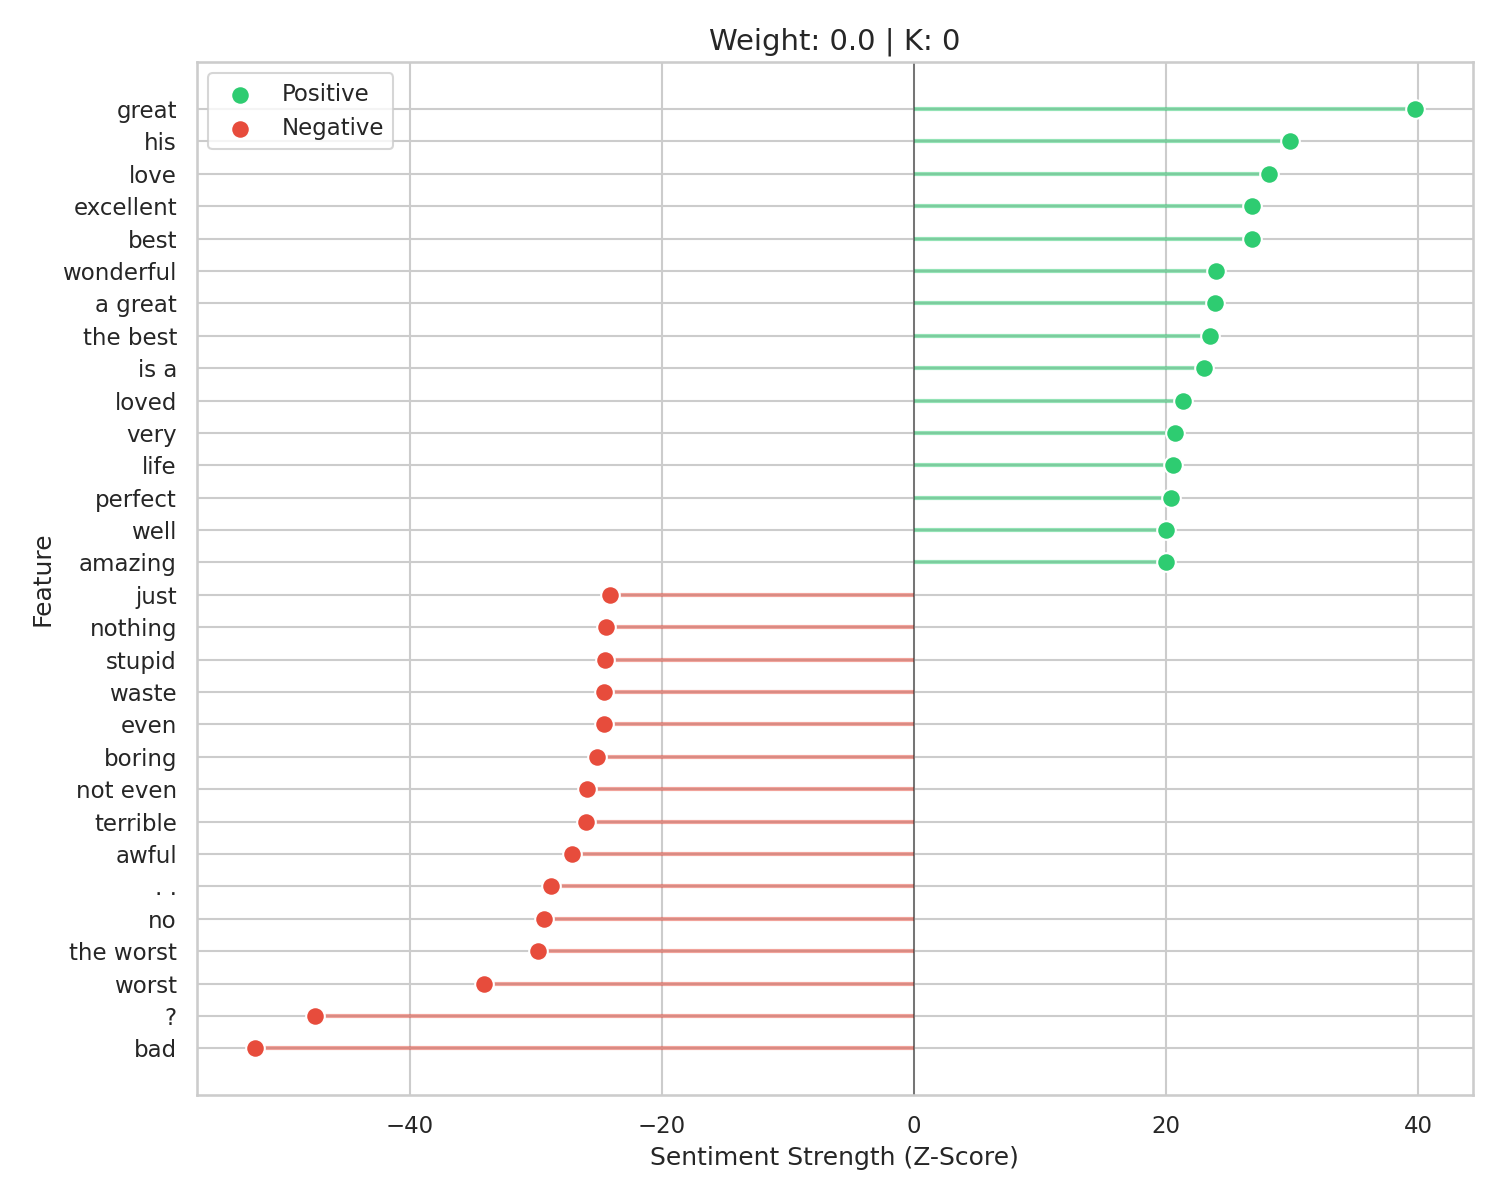


--- Visualizing Semantic Concepts (Clustered) ---

=== COMPARISON: STANDARD vs. AUGMENTED CLUSTERING ===

Analyzing Cluster Specialization for Weight 0...
--- Visualizing: Concepts=5000, Weight=0.0 ---
Saved importance plot to /home/janek/Projekty/Sentiment/results/figures/vocabulary/ngram_1_3_k5000_w0_importance.png
✅ Saved Positive cluster grid to /home/janek/Projekty/Sentiment/results/figures/vocabulary/top_5_Positive_w0.png
✅ Saved Negative cluster grid to /home/janek/Projekty/Sentiment/results/figures/vocabulary/top_5_Negative_w0.png

Analyzing Cluster Specialization for Weight 30...
--- Visualizing: Concepts=5000, Weight=30.0 ---
Saved importance plot to /home/janek/Projekty/Sentiment/results/figures/vocabulary/ngram_1_3_k5000_w30_importance.png
✅ Saved Positive cluster grid to /home/janek/Projekty/Sentiment/results/figures/vocabulary/top_5_Positive_w30.png
✅ Saved Negative cluster grid to /home/janek/Projekty/Sentiment/results/figures/vocabulary/top_5_Negative_w30.png


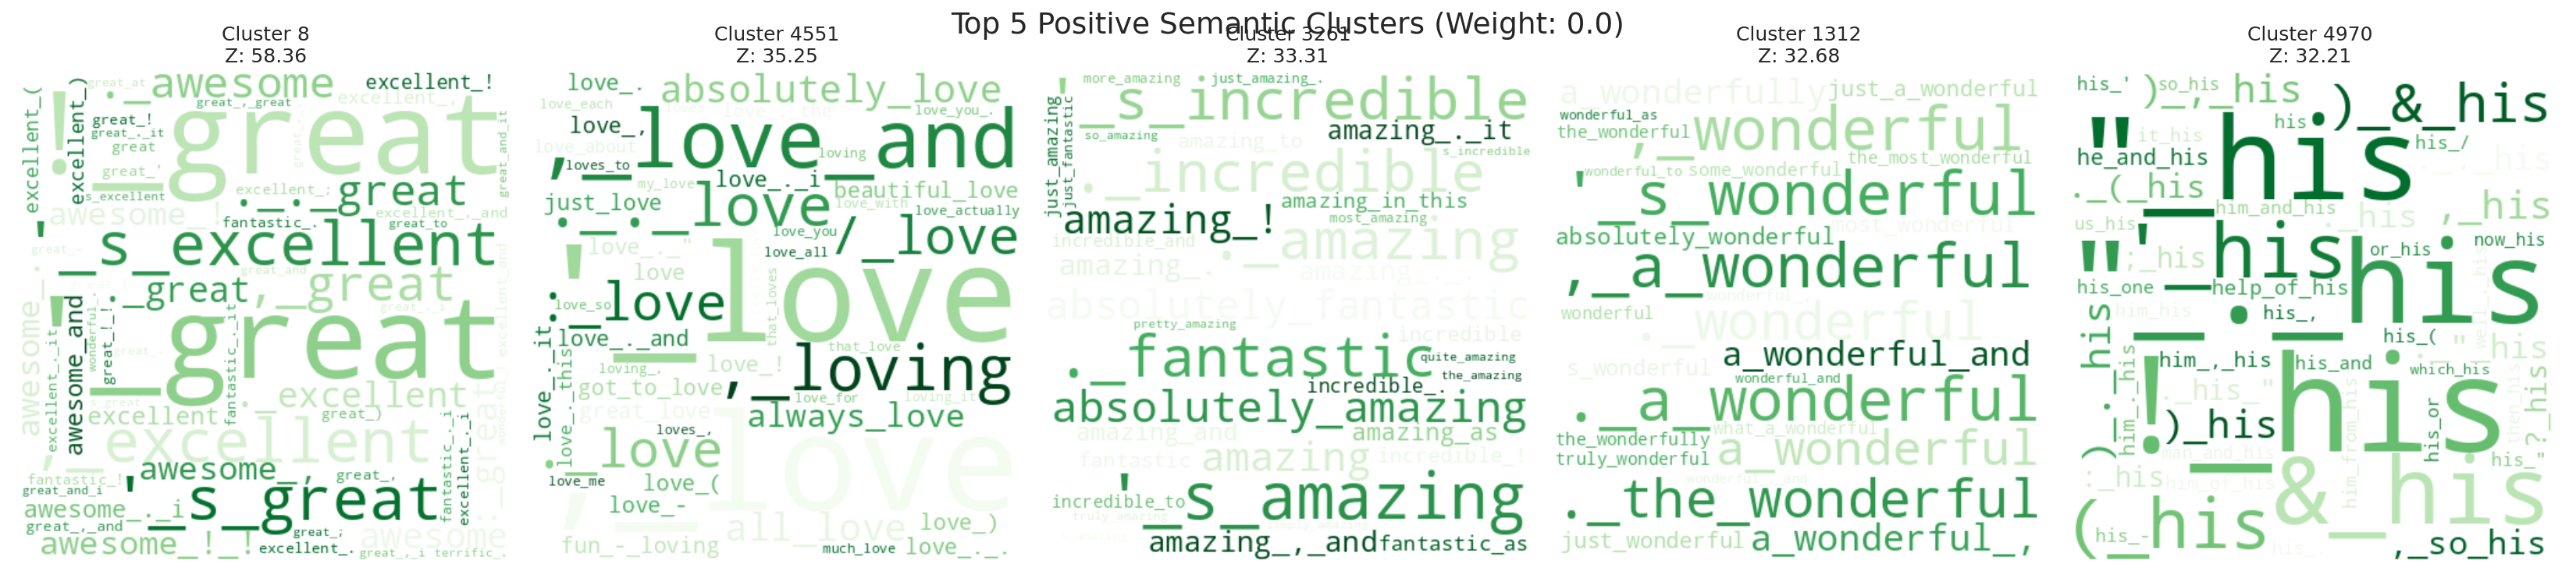

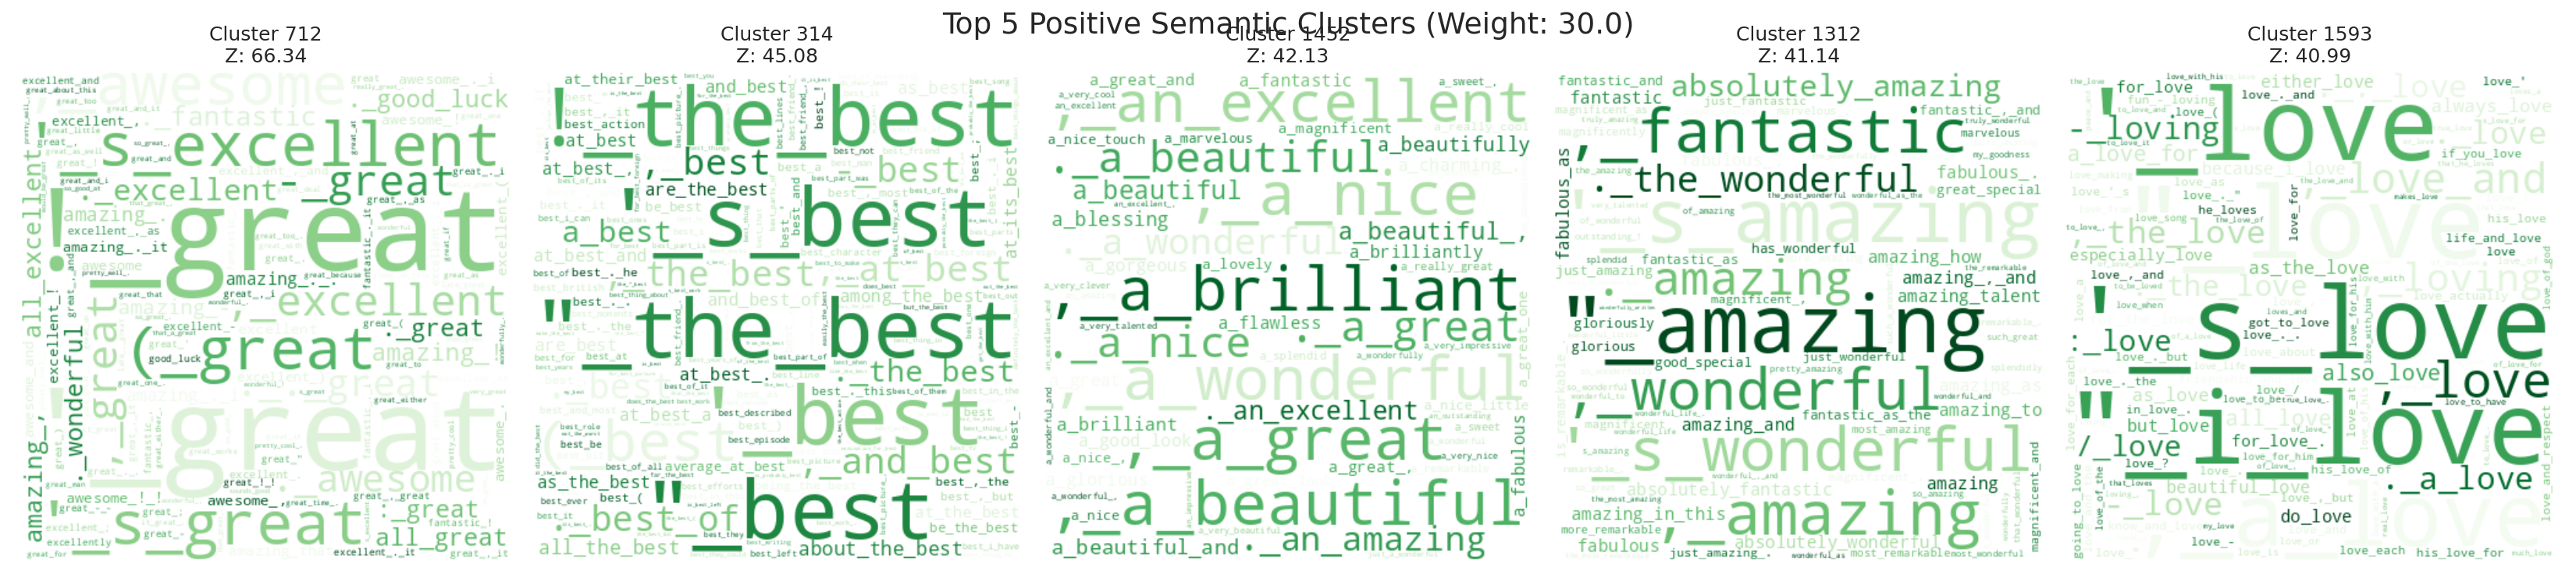

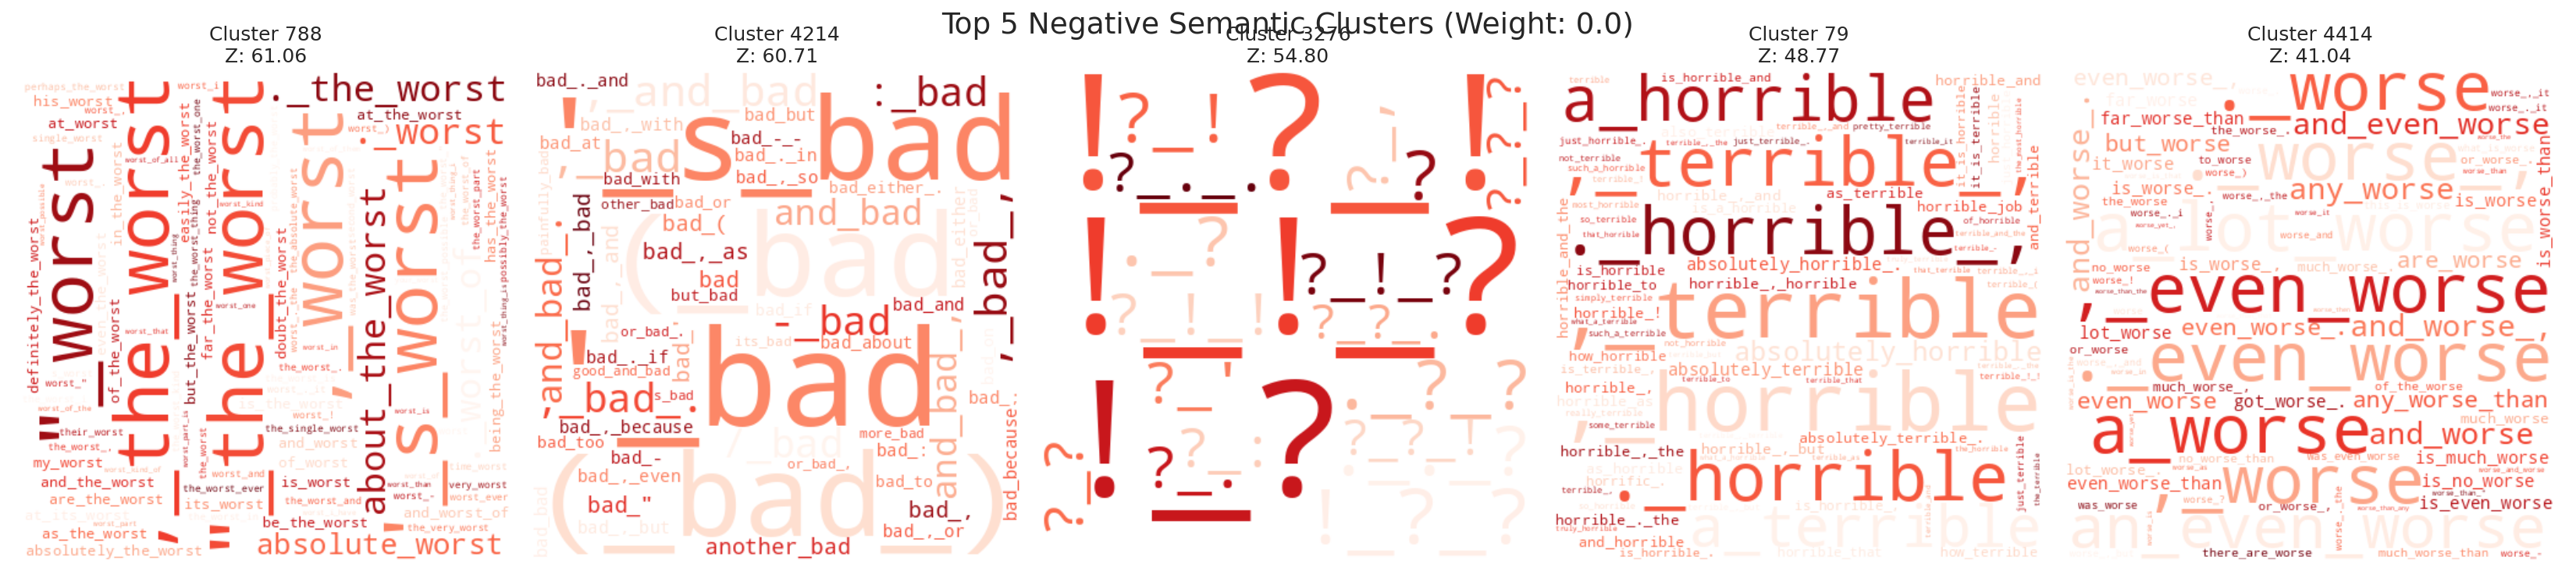

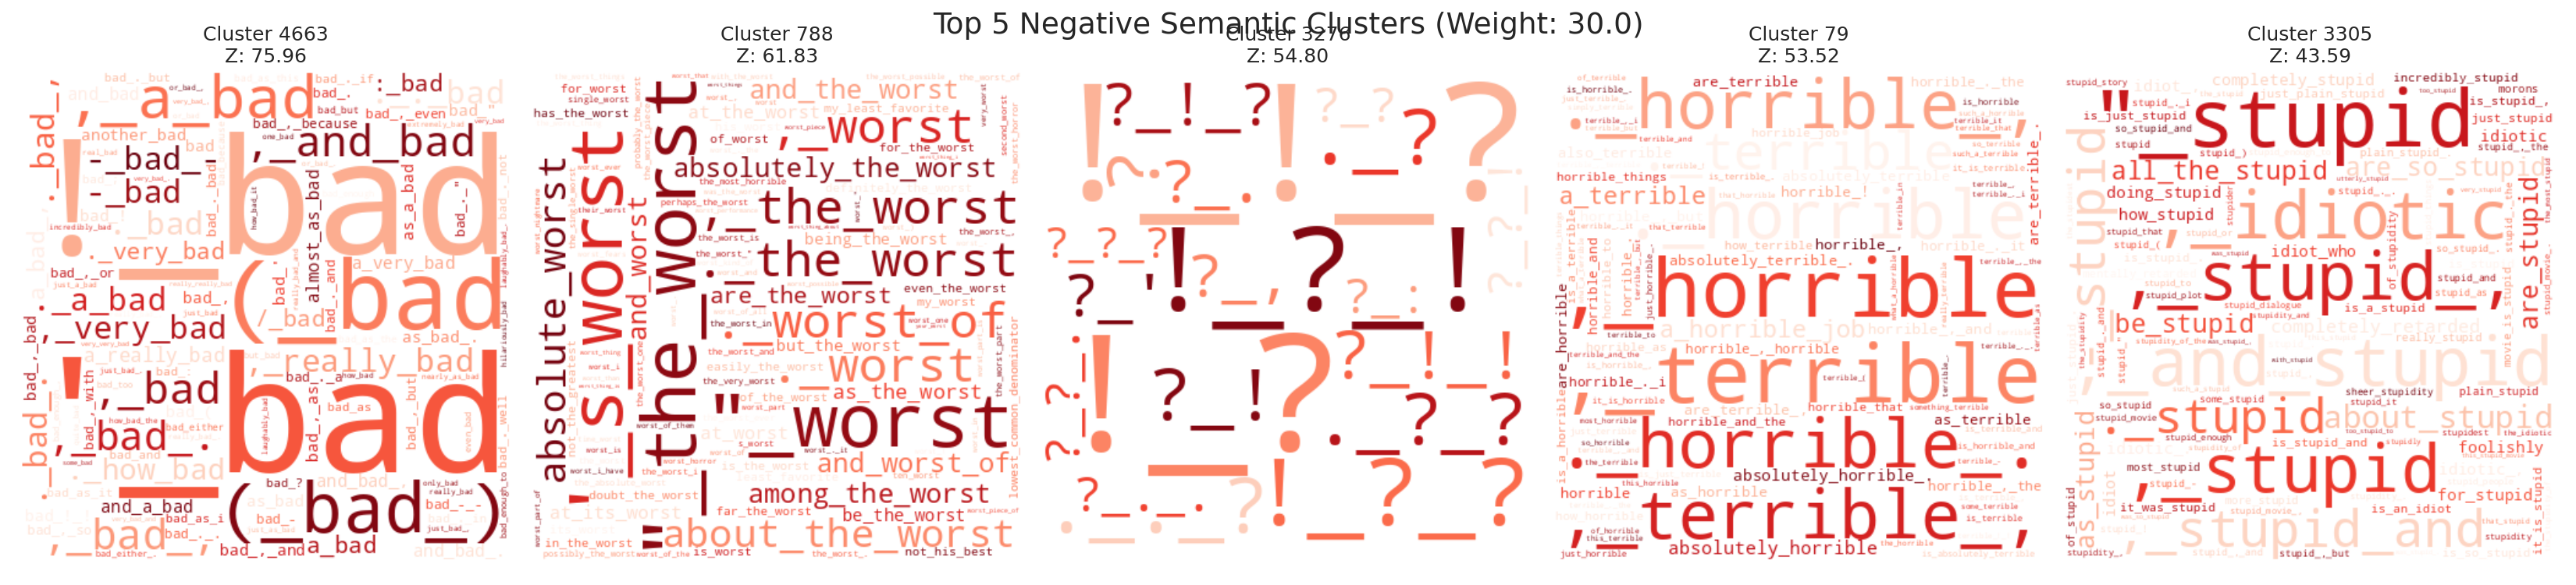

In [10]:
print("\n--- Visualizing Unigrams (Baseline) ---")
!python -m scripts.visualize_sentiment --nmin 1 --nmax 1 --n_concepts 0 --sentiment_weight 0
display(Image("results/figures/vocabulary/ngram_1_1_k0_w0_importance.png"))
!python -m scripts.visualize_sentiment --nmin 1 --nmax 3 --n_concepts 0 --sentiment_weight 0
display(Image("results/figures/vocabulary/ngram_1_3_k0_w0_importance.png"))

print("\n--- Visualizing Semantic Concepts (Clustered) ---")
from IPython.display import Image, display

print("\n=== COMPARISON: STANDARD vs. AUGMENTED CLUSTERING ===")
for weight in [0, 30]:
    print(f"\nAnalyzing Cluster Specialization for Weight {weight}...")
    !python -m scripts.visualize_sentiment \
        --nmin 1 --nmax 3 --n_concepts 5000 --sentiment_weight {weight} --top_n 5

display(Image("results/figures/vocabulary/top_5_Positive_w0.png"))
display(Image("results/figures/vocabulary/top_5_Positive_w30.png"))

display(Image("results/figures/vocabulary/top_5_Negative_w0.png"))
display(Image("results/figures/vocabulary/top_5_Negative_w30.png"))

In [11]:
# 4. Run Grid Evaluation
!python -m scripts.grid_search --config configs/default.yaml --workers 1

/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Dask Dashboard available at: http://127.0.0.1:8787/status
🚀 Starting Grid Search with 168 iterations...
Grid Search Progress: 100%|███████████████████| 168/168 [06:35<00:00,  2.36s/it]

✅ Completed: 168


In [8]:
# 3. Train BERT Baseline
!python -m scripts.train_bert --config configs/default.yaml


>>> Training Basic BERT Baseline <<<
I0000 00:00:1771355318.283358    9330 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Epoch 1/3
      1/Unknown - 14s 14s/step - loss: 0.6426 - accuracy: 0.8125I0000 00:00:1771355391.797775    9359 device_compiler.h:196] Compiled cluster using XLA!  This line is lo


🔍 Sweeping Certainty Thresholds for Exact Hybrid Optimization...

🏆 CASCADE OPTIMIZATION WINNER: linear_svm_ng1-3_k0_w0_z1.96
-> Peak Global System Accuracy: 93.24% (Beats Base BERT by +1.71%)
-> Required Model Certainty: 75.6% (Accepts probs >= 0.756 or <= 0.244)
-> Data Delegated to BERT: 13.58% (SVM handles 86.42%)
📊 Saved Trade-off graphs to: /home/janek/Projekty/Sentiment/results/figures/analysis/accuracy_coverage_tradeoff.png
<IPython.core.display.Image object>


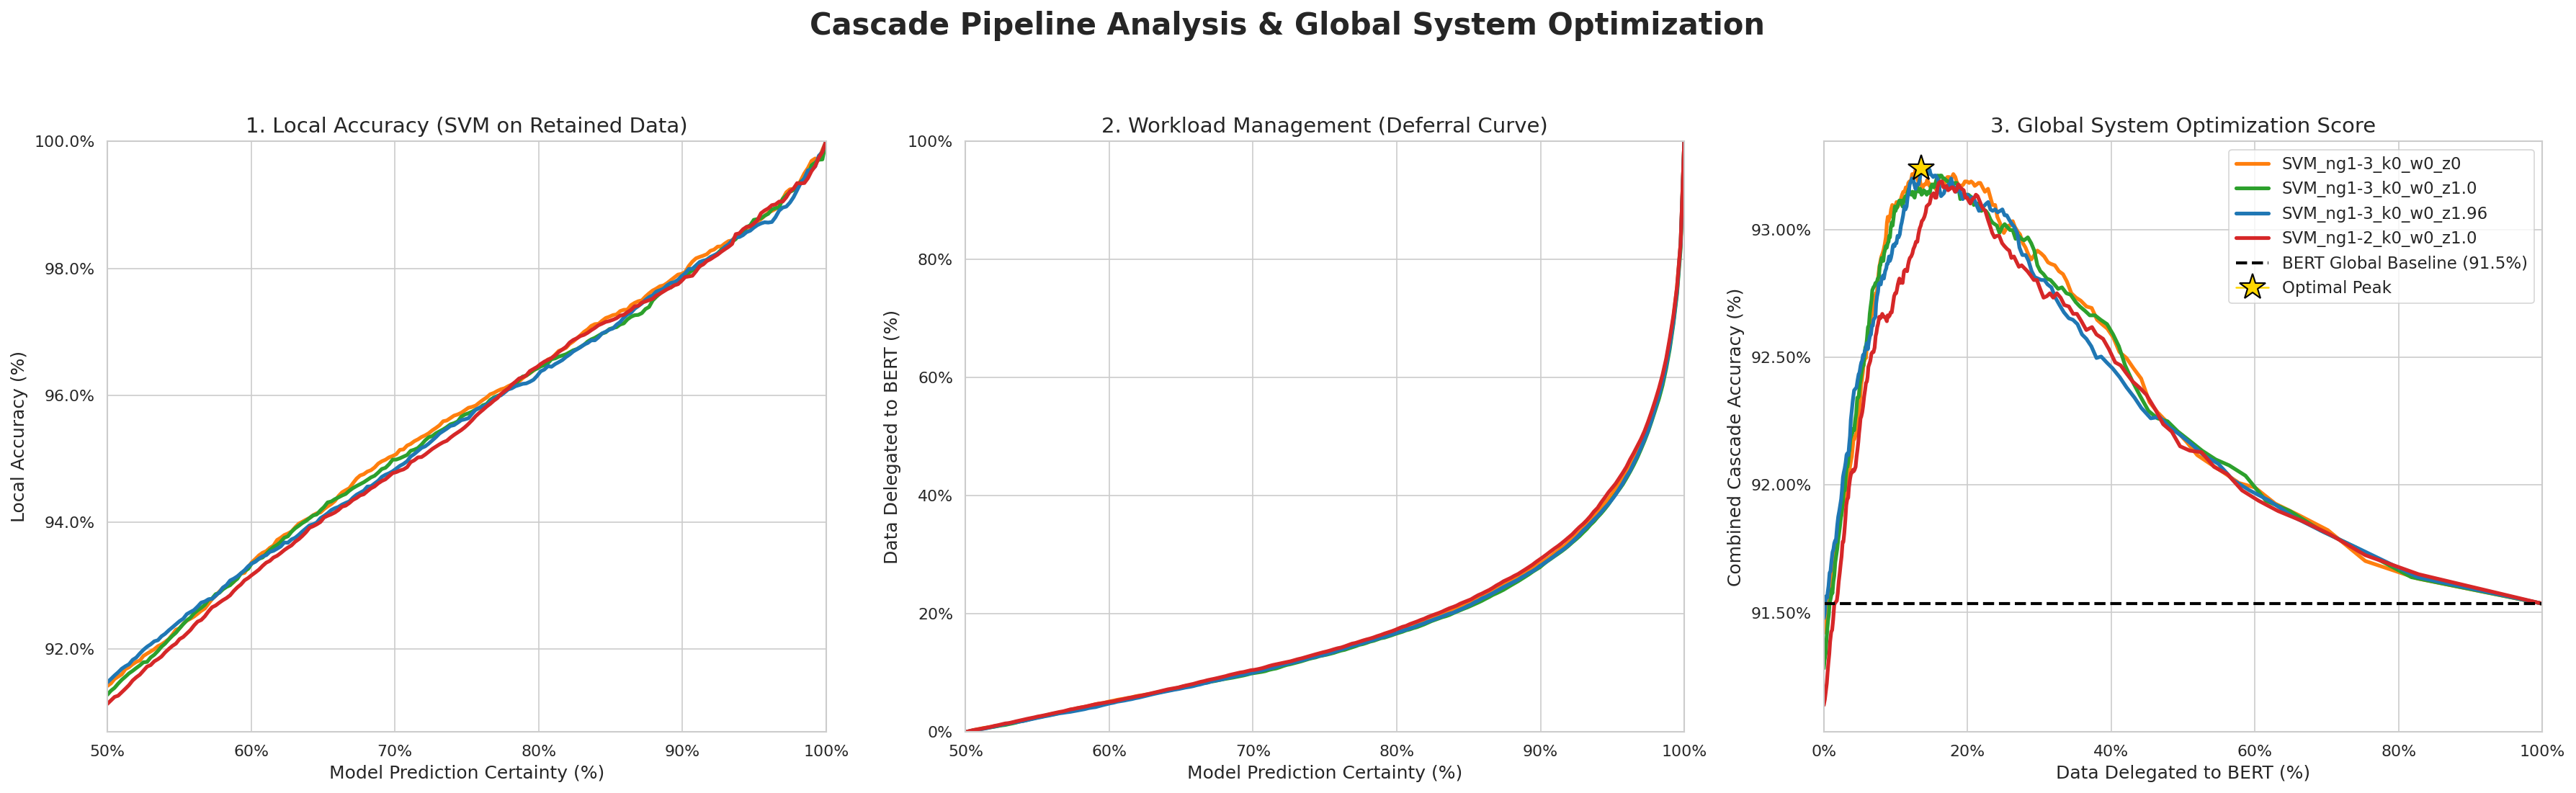

In [12]:
# 5. Find Optimal Threshold & Save Best Params
!python -m scripts.analyse_results
display(Image("results/figures/analysis/accuracy_coverage_tradeoff.png"))

✅ Saved clean trellis graph to: /home/janek/Projekty/Sentiment/results/figures/analysis/zscore_full_trellis.png
<IPython.core.display.Image object>


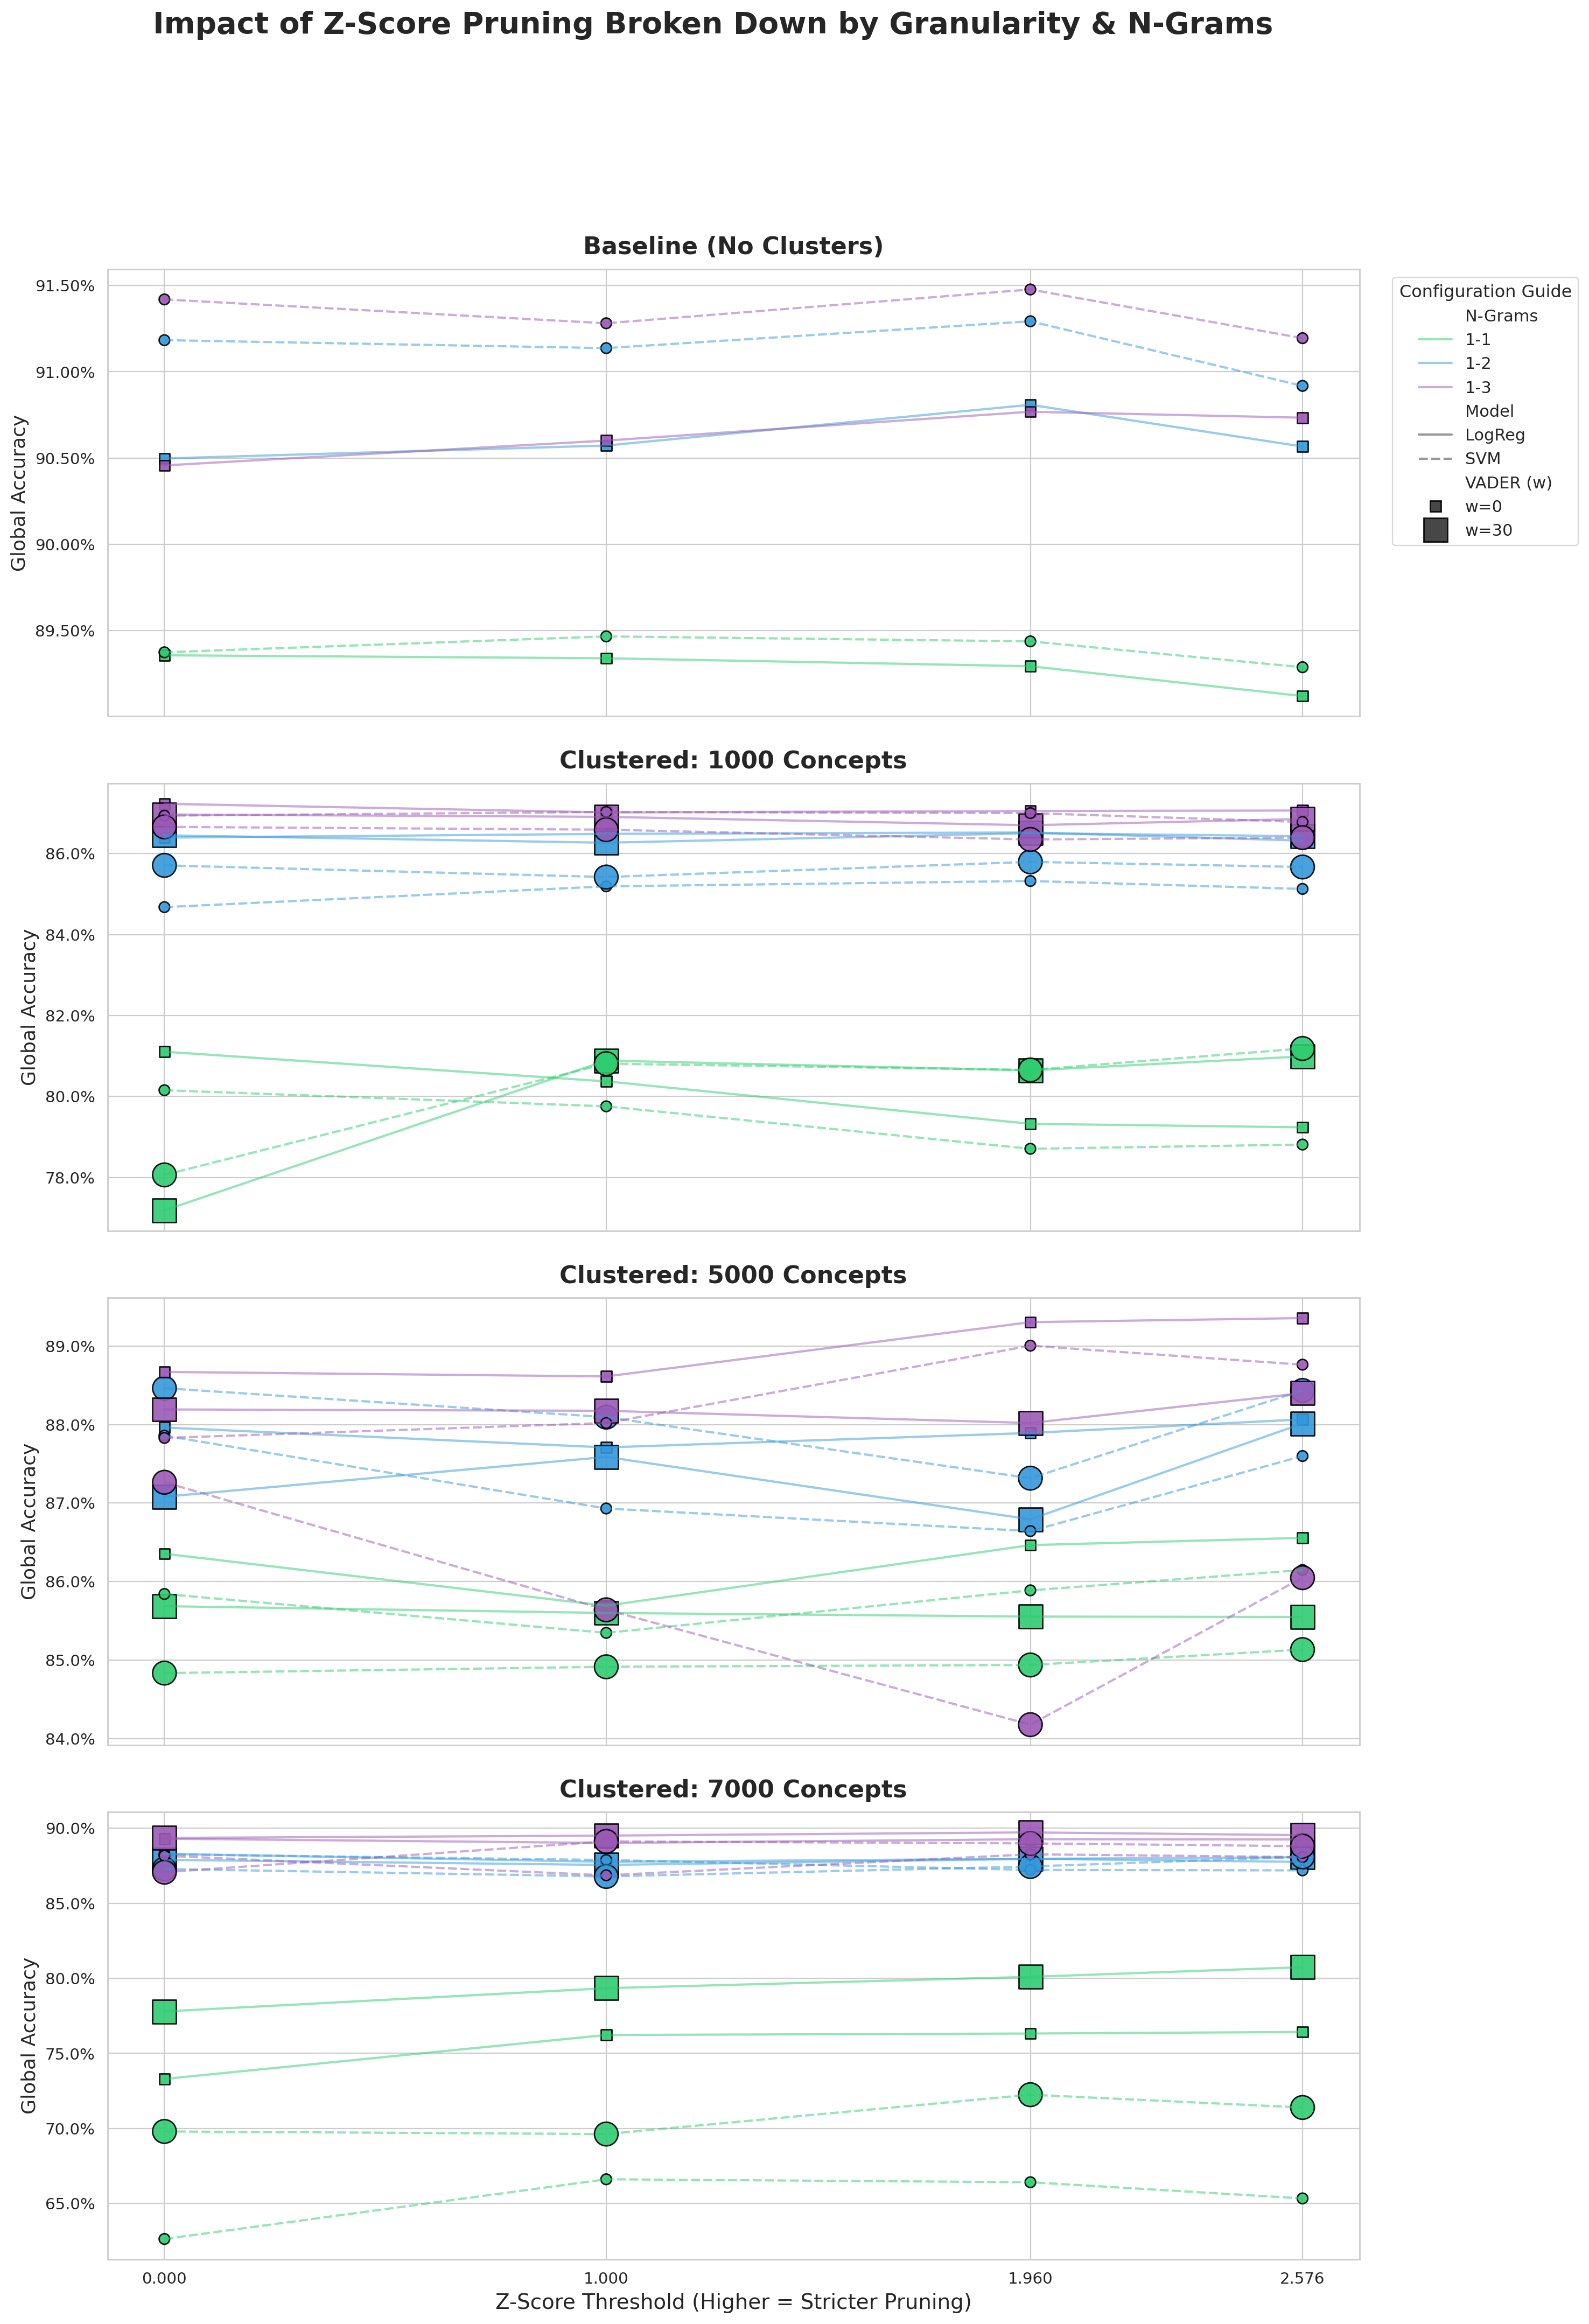

In [13]:
!python -m scripts.param_analysis
display(Image("results/figures/analysis/zscore_full_trellis.png"))


--- Model Comparison: Baseline vs Clustered Concepts ---

🏆 === CHAMPION MODELS SUMMARY === 🏆
Best Baseline SVM (Non-Clustered):
  -> Config: linear_svm_ng1-3_k0_w0_z1.96
  -> Accuracy: 0.9148

Best Concept SVM (Clustered):
  -> Config: linear_svm_ng1-3_k7000_w30_z1.0
  -> Accuracy: 0.8912

Best Baseline LogReg (Non-Clustered):
  -> Config: logreg_ng1-2_k0_w0_z1.96
  -> Accuracy: 0.9081

Best Concept LogReg (Clustered):
  -> Config: logreg_ng1-3_k7000_w30_z1.96
  -> Accuracy: 0.8972

📊 Saved confusion matrix grid to: /home/janek/Projekty/Sentiment/results/figures/analysis/champion_confusion_matrices.png


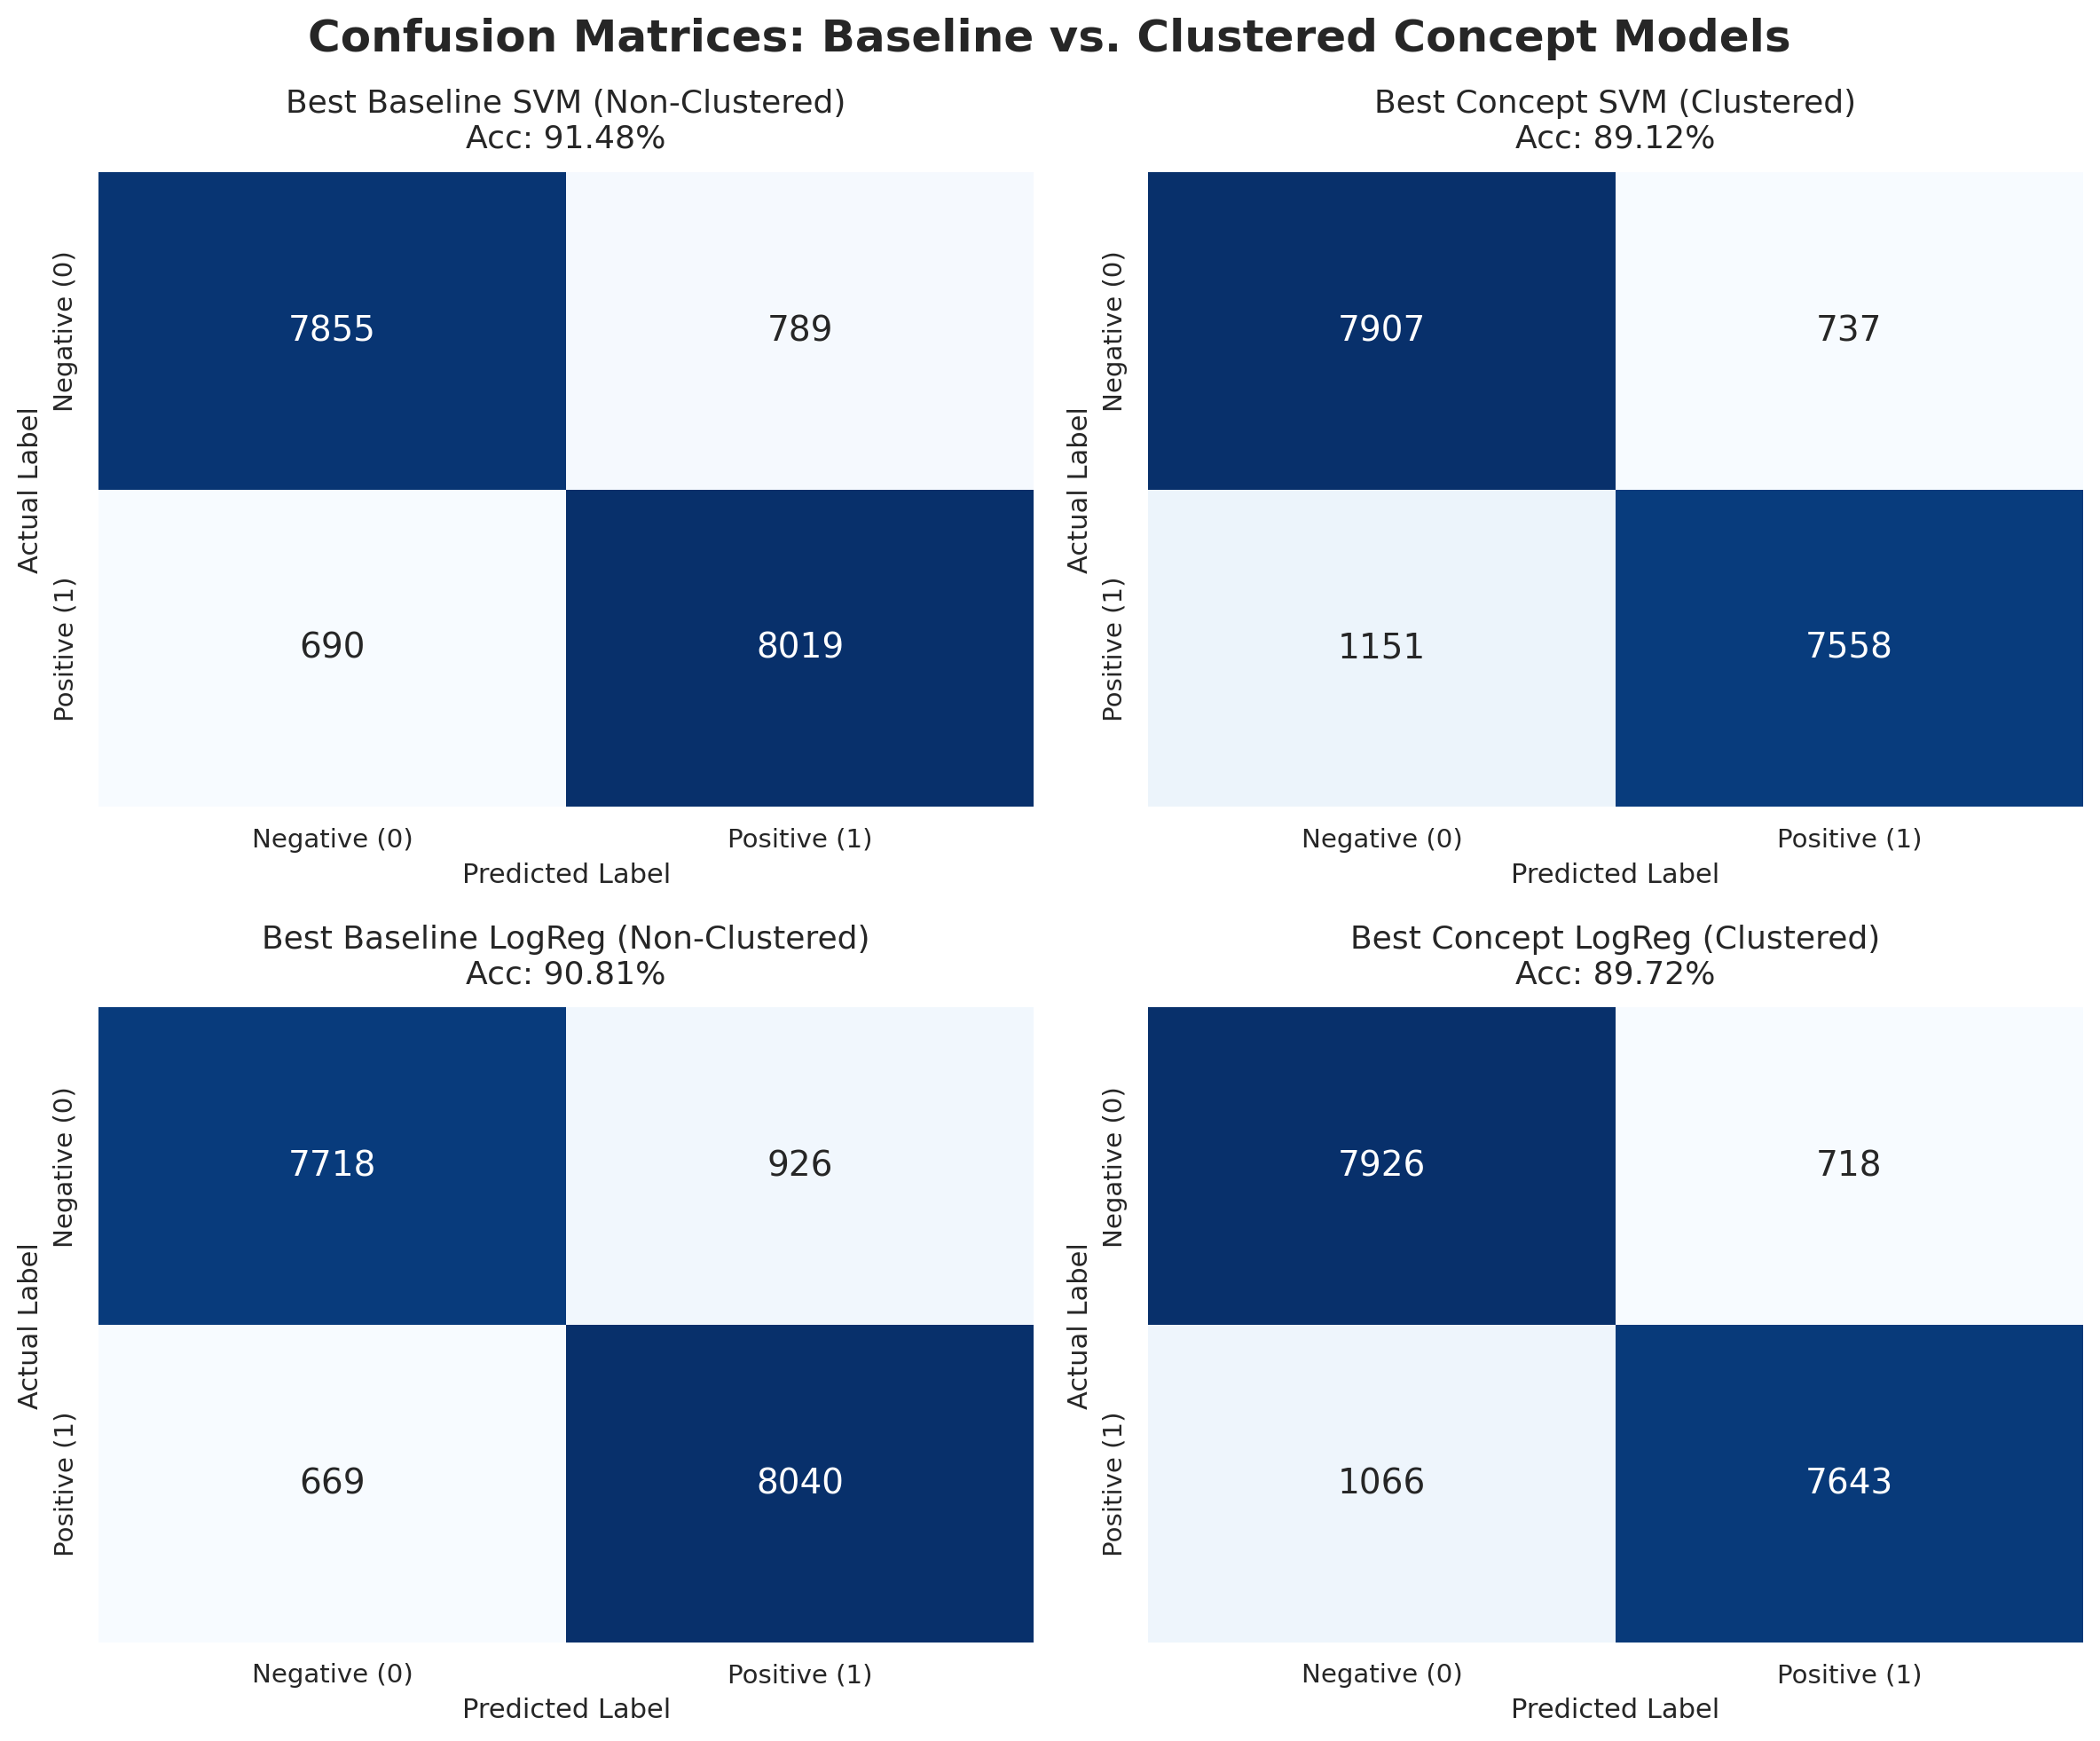

In [14]:
print("\n--- Model Comparison: Baseline vs Clustered Concepts ---")
!python -m scripts.compare_models
display(Image("results/figures/analysis/champion_confusion_matrices.png"))

In [16]:
print("--- Step 6: Train Specialist BERT (Transfer Learning) ---")
!python -m scripts.train_specialist --config configs/default.yaml --best_params configs/best_params.yaml

--- Step 6: Train Specialist BERT (Transfer Learning) ---
Loading data...

Training SVM with best parameters...
SVM saved to /home/janek/Projekty/Sentiment/models/svm_base.joblib
Validation hard samples: 2353 (13.56%)
I0000 00:00:1771423995.492823    2393 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6

Fine‑tuning specialist BERT on hard samples...
Epoch 1/3
I0000 00:00:1771424012.185199    2421 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
236/236 [==============================] - 45s 147ms/step - loss: 0.5714 - accuracy: 0.7083 - val_loss: 0.5643 - val_accuracy: 0.7028 - lr: 1.0000e-05
Epoch 2/3
236/236 [==============================] - 27s 114ms/step - loss: 0.5310 - accuracy: 0.7349 - val_loss: 0.5683 - val_accuracy: 0.7091 - lr: 1.0000e-05
Epoch 3/3


In [17]:
print("--- Step 7: Run Ensemble (Cascade Evaluation) ---")
!python -m scripts.run_ensemble --config configs/default.yaml --best_params configs/best_params.yaml

--- Step 7: Run Ensemble (Cascade Evaluation) ---
I0000 00:00:1771424834.832960    3519 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6

=== CASCADE ENSEMBLE RESULTS ===
SVM                      : 0.9148
Basic BERT               : 0.8773
Specialist BERT          : 0.8779
SVM+Basic Cascade        : 0.9258
SVM+Specialist Cascade   : 0.9246
Delegation rate        : 13.71%
Threshold used         : 0.244

Results saved to /home/janek/Projekty/Sentiment/results/thesis/ensemble_results.csv


✅ Thesis figure saved to /home/janek/Projekty/Sentiment/results/figures/thesis/thesis_final_results.png


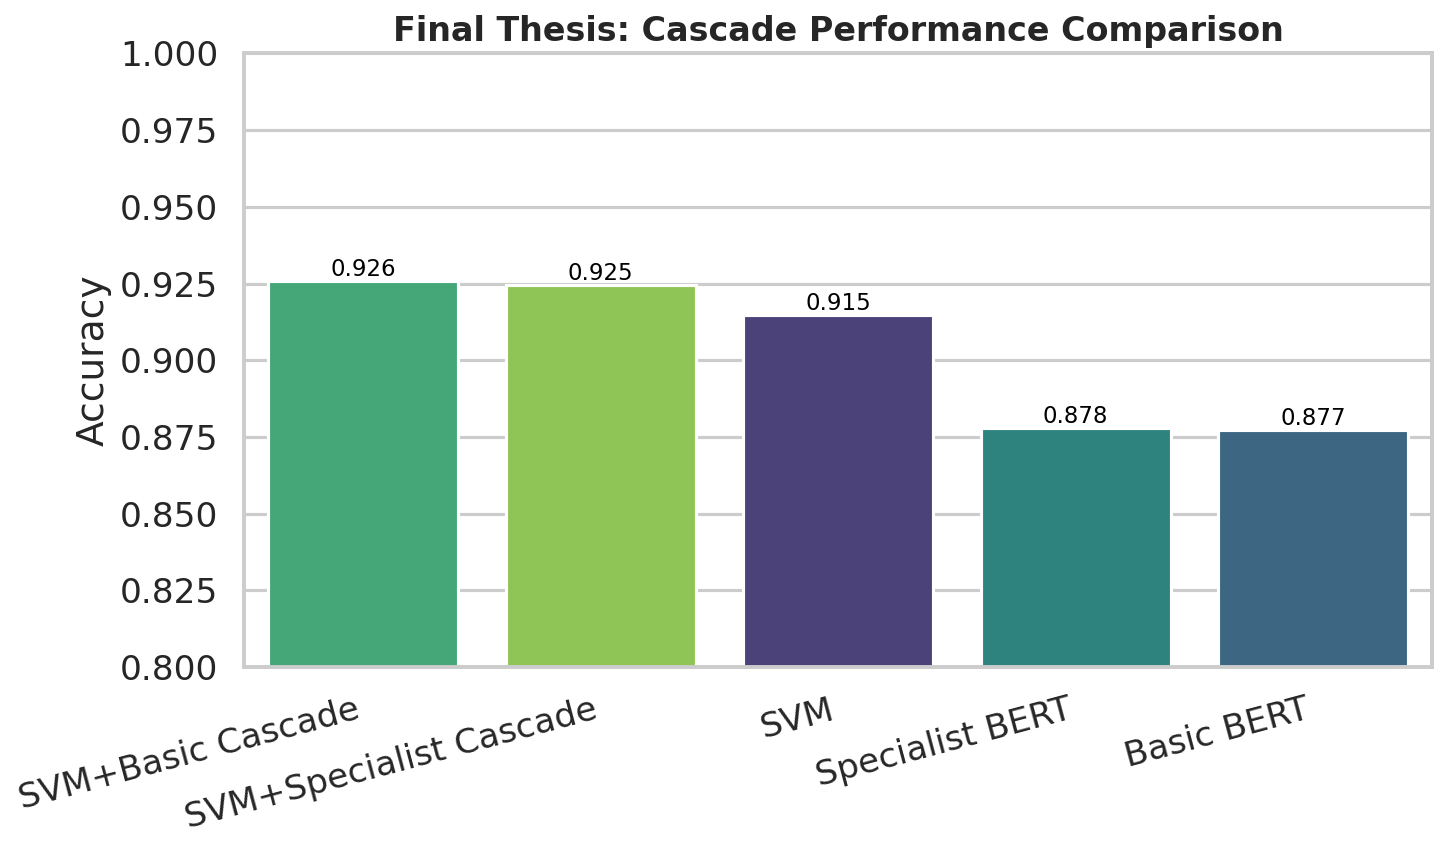

In [18]:
!python -m scripts.visualize_thesis
display(Image("results/figures/thesis/thesis_final_results.png"))